In [59]:
# Apply ML model to predict AQI values for 2020
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aqi as aqi
import joblib

In [60]:
# Read all individual 2020 data files per each quarter
df_2020_Q1 = pd.read_csv('/Users/nkichili/Desktop/Synopsys/waqi-covid19-airqualitydata-2020Q1.csv')
df_2020_Q2 = pd.read_csv('/Users/nkichili/Desktop/Synopsys/waqi-covid19-airqualitydata-2020Q2.csv')
df_2020_Q3 = pd.read_csv('/Users/nkichili/Desktop/Synopsys/waqi-covid19-airqualitydata-2020Q3.csv')
df_2020_Q4 = pd.read_csv('/Users/nkichili/Desktop/Synopsys/waqi-covid19-airqualitydata-2020Q4.csv')

In [61]:
# This current analysis considers only USA as other countries in the data set don't have required pollutant attributes
# USA data set doesn't come up with AQI (Air Quality Index) which needs to be calculated later (mentioned below)
df_2020_Q1_USA = df_2020_Q1.loc[df_2020_Q1['Country'] == 'US']
df_2020_Q2_USA = df_2020_Q2.loc[df_2020_Q2['Country'] == 'US']
df_2020_Q3_USA = df_2020_Q3.loc[df_2020_Q3['Country'] == 'US']
df_2020_Q4_USA = df_2020_Q4.loc[df_2020_Q4['Country'] == 'US']

In [62]:
# Choose only the required columns as we don't need count (samples), min, max, variance. 
cols = ['Date','Country','City','Specie','median']
df_2020_Q1_USA_5 = df_2020_Q1_USA[cols]
df_2020_Q2_USA_5 = df_2020_Q2_USA[cols]
df_2020_Q3_USA_5 = df_2020_Q3_USA[cols]
df_2020_Q4_USA_5 = df_2020_Q4_USA[cols]

In [63]:
# The original data set contains each pollutant by date, city, country in each row which is hard to perform analysis
# Use Pivot to transponse long to wide format so that each row will have Date, Country, City, other polluntant attributes, value
df_2020_Q1_USA_PV = df_2020_Q1_USA_5.pivot(index=['Date','Country','City'], columns='Specie', values='median').reset_index()
df_2020_Q2_USA_PV = df_2020_Q2_USA_5.pivot(index=['Date','Country','City'], columns='Specie', values='median').reset_index()
df_2020_Q3_USA_PV = df_2020_Q3_USA_5.pivot(index=['Date','Country','City'], columns='Specie', values='median').reset_index()
df_2020_Q4_USA_PV = df_2020_Q4_USA_5.pivot(index=['Date','Country','City'], columns='Specie', values='median').reset_index()


In [64]:
# A sample of columns listed below based on the above step execution
df_2020_Q1_USA_PV.columns

Index(['Date', 'Country', 'City', 'co', 'dew', 'humidity', 'no2', 'o3', 'pm10',
       'pm25', 'precipitation', 'pressure', 'so2', 'temperature', 'wd',
       'wind gust', 'wind speed', 'wind-gust', 'wind-speed'],
      dtype='object', name='Specie')

In [65]:
# Air Quality Index (AQI) requires one of pm10 or pm25 and at least total 3 attributes from CO, NO2, O3, PM10, PM25, SO2
# Reference: https://app.cpcbccr.com/ccr_docs/How_AQI_Calculated.pdf
# Refer page#14 in https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf

df_2020_Q1_USA_POLLUTANT = df_2020_Q1_USA_PV[['Date','Country','City', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2']]
df_2020_Q2_USA_POLLUTANT = df_2020_Q2_USA_PV[['Date','Country','City', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2']]
df_2020_Q3_USA_POLLUTANT = df_2020_Q3_USA_PV[['Date','Country','City', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2']]
df_2020_Q4_USA_POLLUTANT = df_2020_Q4_USA_PV[['Date','Country','City', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2']]


In [66]:
# Combine all quarters of 2020 data set
df_2020_USA_FINAL = df_2020_Q1_USA_POLLUTANT.append([df_2020_Q2_USA_POLLUTANT, df_2020_Q3_USA_POLLUTANT, df_2020_Q4_USA_POLLUTANT])
df_2020_USA_FINAL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22031 entries, 0 to 5487
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     22031 non-null  object 
 1   Country  22031 non-null  object 
 2   City     22031 non-null  object 
 3   co       16073 non-null  float64
 4   no2      15307 non-null  float64
 5   o3       20951 non-null  float64
 6   pm10     10226 non-null  float64
 7   pm25     21832 non-null  float64
 8   so2      9486 non-null   float64
dtypes: float64(6), object(3)
memory usage: 1.7+ MB


In [67]:
# The above info shows that there are lot of missing values for pollutants (Eg: Out of 22031 entries, pm25 has values for 21832 only)
df_2020_USA_FINAL.head(5)

Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2
0,2019-12-30,US,Albuquerque,2.4,6.5,24.8,9.0,16.0,NaN
1,2019-12-30,US,Atlanta,1.7,3.8,24.1,7.0,15.0,NaN
2,2019-12-30,US,Austin,NaN,NaN,21.6,NaN,13.0,NaN
3,2019-12-30,US,Baltimore,NaN,11.2,12.1,NaN,14.0,NaN
4,2019-12-30,US,Boise,2.6,7.5,16.0,10.0,30.0,NaN


<AxesSubplot:xlabel='Specie'>

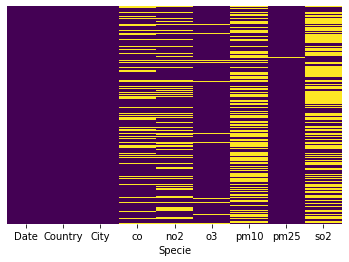

In [68]:
# The below heatmap shows missing values (yellow color) for different pollutants
sns.heatmap(df_2020_USA_FINAL.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [69]:
# Fill the missing values of pollutants by taking mean of that pollutant for that country and city
df_2020_USA_FINAL['pm10'] = df_2020_USA_FINAL.groupby(["Country", "City"])['pm10'].transform(lambda x: x.fillna(x.mean()))
df_2020_USA_FINAL['pm25'] = df_2020_USA_FINAL.groupby(["Country", "City"])['pm25'].transform(lambda x: x.fillna(x.mean()))
df_2020_USA_FINAL['no2'] = df_2020_USA_FINAL.groupby(["Country", "City"])['no2'].transform(lambda x: x.fillna(x.mean()))
df_2020_USA_FINAL['so2'] = df_2020_USA_FINAL.groupby(["Country", "City"])['so2'].transform(lambda x: x.fillna(x.mean()))
df_2020_USA_FINAL['co'] = df_2020_USA_FINAL.groupby(["Country", "City"])['co'].transform(lambda x: x.fillna(x.mean()))
df_2020_USA_FINAL['o3'] = df_2020_USA_FINAL.groupby(["Country", "City"])['o3'].transform(lambda x: x.fillna(x.mean()))

In [70]:
df_2020_USA_FINAL.columns

Index(['Date', 'Country', 'City', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2'], dtype='object', name='Specie')

<AxesSubplot:xlabel='Specie'>

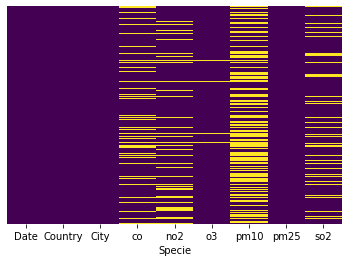

In [71]:
# After filling the missing values with mean of the specific pollutant as stated above, this heatmap still shows some missing values
sns.heatmap(df_2020_USA_FINAL.isnull(),yticklabels=False,cbar=False,cmap='viridis')


In [72]:
#Before applying mean for missing values, so2 had values for 9486 entries only but after applying mean, so2 has values for 16938
df_2020_USA_FINAL.info()
df_2020_USA_FINAL.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22031 entries, 0 to 5487
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     22031 non-null  object 
 1   Country  22031 non-null  object 
 2   City     22031 non-null  object 
 3   co       17475 non-null  float64
 4   no2      17471 non-null  float64
 5   o3       21783 non-null  float64
 6   pm10     11368 non-null  float64
 7   pm25     22031 non-null  float64
 8   so2      16938 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.7+ MB


Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2
0,2019-12-30,US,Albuquerque,2.4,6.500000,24.8,9.000000,16.0,1.511475
1,2019-12-30,US,Atlanta,1.7,3.800000,24.1,7.000000,15.0,0.514706
2,2019-12-30,US,Austin,NaN,3.222785,21.6,NaN,13.0,0.400000
3,2019-12-30,US,Baltimore,NaN,11.200000,12.1,11.647696,14.0,1.679487
4,2019-12-30,US,Boise,2.6,7.500000,16.0,10.000000,30.0,0.784647


In [73]:
# This time, fill the missing value of mean of a particular pollutant based on all rows of that column instead of restricting with specific cities
df_2020_USA_FINAL['pm10'] = df_2020_USA_FINAL['pm10'].fillna(df_2020_USA_FINAL['pm10'].mean())
df_2020_USA_FINAL['pm25'] = df_2020_USA_FINAL['pm25'].fillna(df_2020_USA_FINAL['pm25'].mean())
df_2020_USA_FINAL['no2'] = df_2020_USA_FINAL['no2'].fillna(df_2020_USA_FINAL['no2'].mean())
df_2020_USA_FINAL['so2'] = df_2020_USA_FINAL['so2'].fillna(df_2020_USA_FINAL['so2'].mean())
df_2020_USA_FINAL['co'] = df_2020_USA_FINAL['co'].fillna(df_2020_USA_FINAL['co'].mean())
df_2020_USA_FINAL['o3'] = df_2020_USA_FINAL['o3'].fillna(df_2020_USA_FINAL['o3'].mean())
df_2020_USA_FINAL

Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2
0,2019-12-30,US,Albuquerque,2.400000,6.500000,24.8,9.000000,16.0,1.511475
1,2019-12-30,US,Atlanta,1.700000,3.800000,24.1,7.000000,15.0,0.514706
2,2019-12-30,US,Austin,3.188743,3.222785,21.6,18.581864,13.0,0.400000
3,2019-12-30,US,Baltimore,3.188743,11.200000,12.1,11.647696,14.0,1.679487
4,2019-12-30,US,Boise,2.600000,7.500000,16.0,10.000000,30.0,0.784647
...,...,...,...,...,...,...,...,...,...
5483,2021-01-03,US,Staten Island,4.300000,21.300000,11.2,18.581864,35.0,1.500000
5484,2021-01-03,US,Tallahassee,1.489492,7.547803,8.2,18.581864,28.0,0.173973
5485,2021-01-03,US,The Bronx,2.400000,13.714130,16.0,18.581864,39.0,1.203967
5486,2021-01-03,US,Tucson,2.900000,12.800000,15.2,18.000000,25.0,0.300000


<AxesSubplot:xlabel='Specie'>

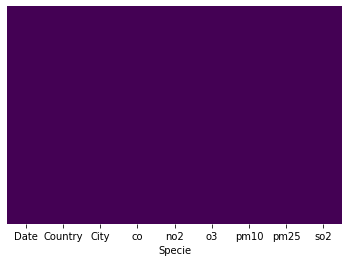

In [74]:
# WIth the above fill of missing values, now the heatmap doesn't show any yellow spots. So, there are no missing values in the data set now
sns.heatmap(df_2020_USA_FINAL.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [75]:
# This shows all pollutants have values as it matches total number of entries (22031)
df_2020_USA_FINAL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22031 entries, 0 to 5487
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     22031 non-null  object 
 1   Country  22031 non-null  object 
 2   City     22031 non-null  object 
 3   co       22031 non-null  float64
 4   no2      22031 non-null  float64
 5   o3       22031 non-null  float64
 6   pm10     22031 non-null  float64
 7   pm25     22031 non-null  float64
 8   so2      22031 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.7+ MB


<AxesSubplot:xlabel='City'>

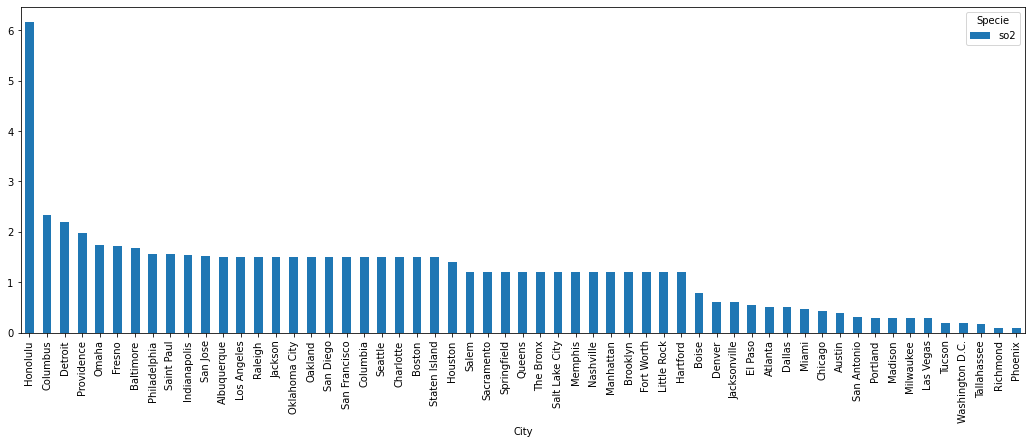

In [76]:
df_2020_USA_FINAL[['so2', 'City']].groupby(['City']).median().sort_values("so2", ascending = False).plot.bar(figsize=(18,6))

<AxesSubplot:xlabel='City'>

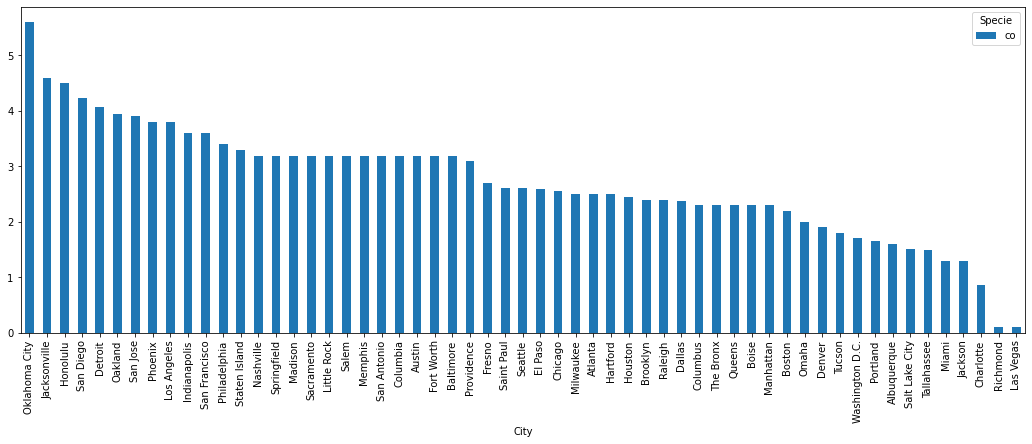

In [77]:
df_2020_USA_FINAL[['co', 'City']].groupby(['City']).median().sort_values("co", ascending = False).plot.bar(figsize=(18,6))


<AxesSubplot:xlabel='City'>

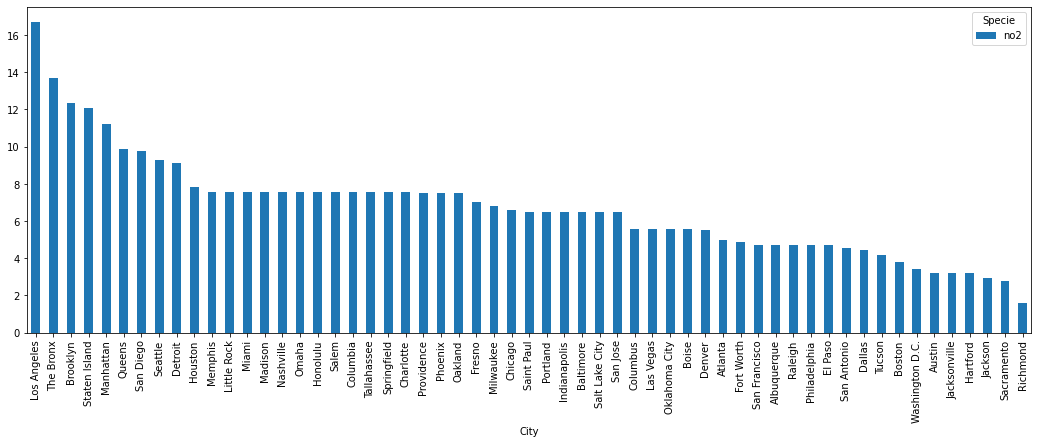

In [78]:
df_2020_USA_FINAL[['no2', 'City']].groupby(['City']).median().sort_values("no2", ascending = False).plot.bar(figsize=(18,6))

<AxesSubplot:xlabel='City'>

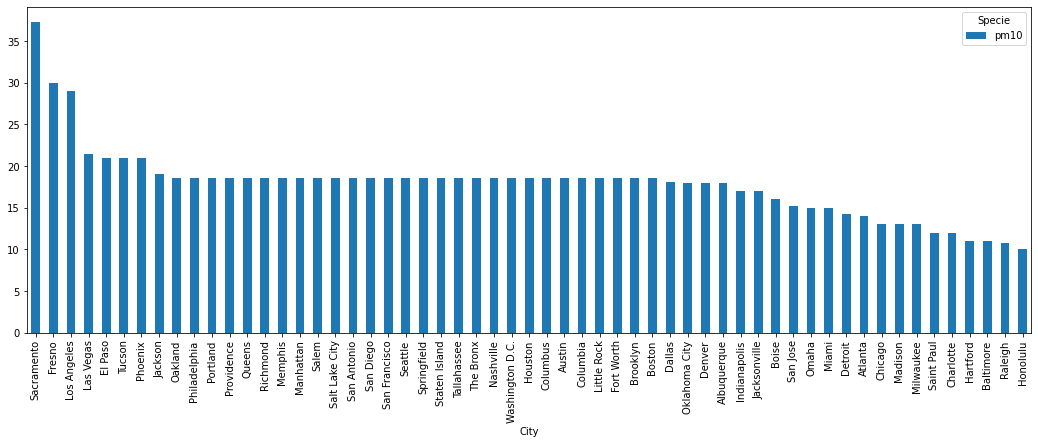

In [79]:
df_2020_USA_FINAL[['pm10', 'City']].groupby(['City']).median().sort_values("pm10", ascending = False).plot.bar(figsize=(18,6))

Distribution of different pollutants


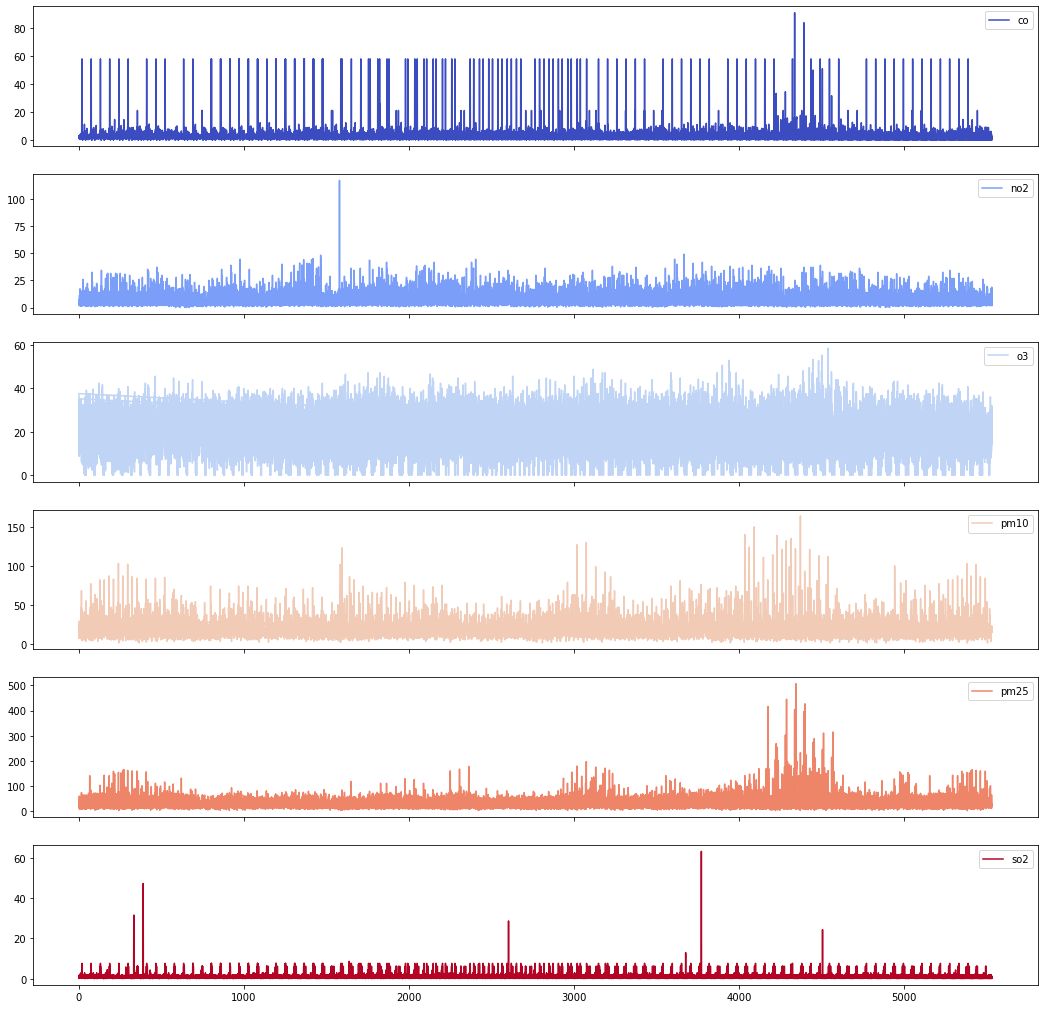

In [80]:
# This is just exploratory data analysis to plot pollutant in 2020
pollutants = ['co', 'no2', 'o3', 'pm10', 'pm25', 'so2']

df_2020_USA_FINAL_PLT = df_2020_USA_FINAL[pollutants]

print('Distribution of different pollutants')
df_2020_USA_FINAL_PLT.plot(kind='line',figsize=(18,18),cmap='coolwarm',subplots=True,fontsize=10);

<AxesSubplot:xlabel='Specie', ylabel='Specie'>

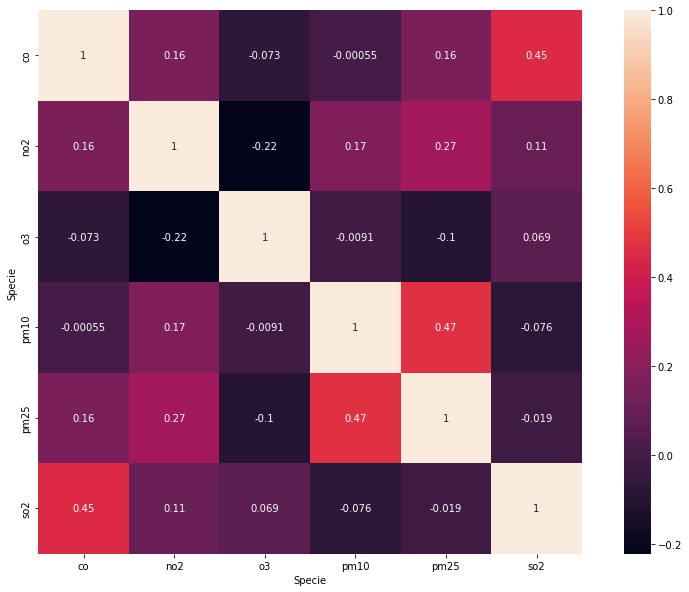

In [81]:
corrmat = df_2020_USA_FINAL[pollutants].corr()
f, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(corrmat, vmax = 1, square = True, annot = True)

In [82]:
def top_and_bottom_10_states(indicator="so2"):
    fig, ax = plt.subplots(2,1, figsize=(20, 12))
    
    ind = df_2020_USA_FINAL[[indicator, 'City']].groupby('City', as_index=False).median().sort_values(by=indicator,ascending=False)
    top10 = sns.barplot(x='City', y=indicator, data=ind[:10], ax=ax[0])
    top10.set_title("Top 10 states by {} (2020)".format(indicator))
    top10.set_ylabel(indicator)
    top10.set_xlabel("City")
    
    bottom10 = sns.barplot(x='City', y=indicator, data=ind[-10:], ax=ax[1])
    bottom10.set_title("Bottom 10 states by {} (2020)".format(indicator))
    bottom10.set_ylabel(indicator)
    bottom10.set_xlabel("City")

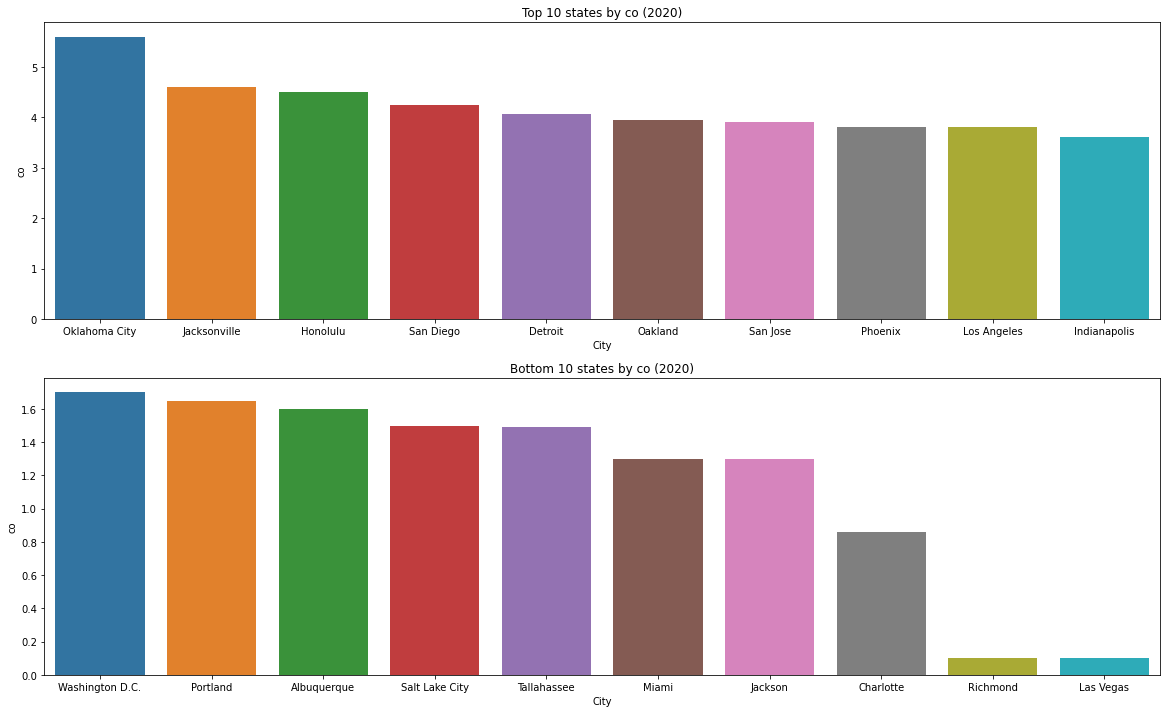

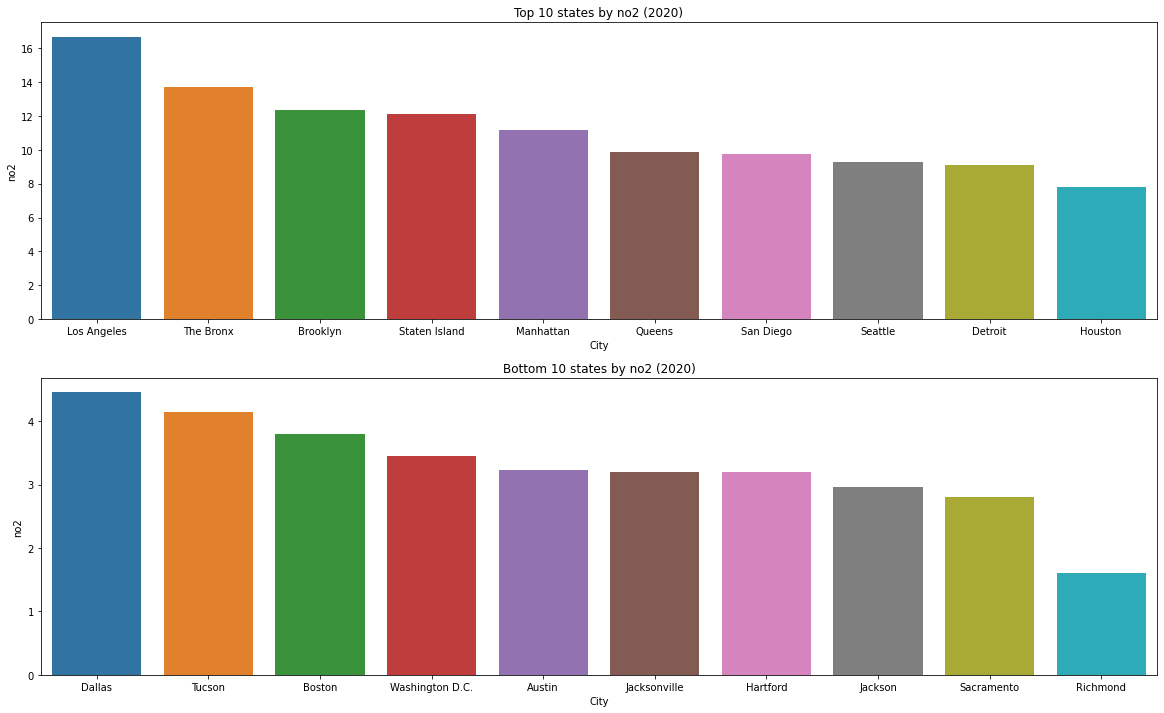

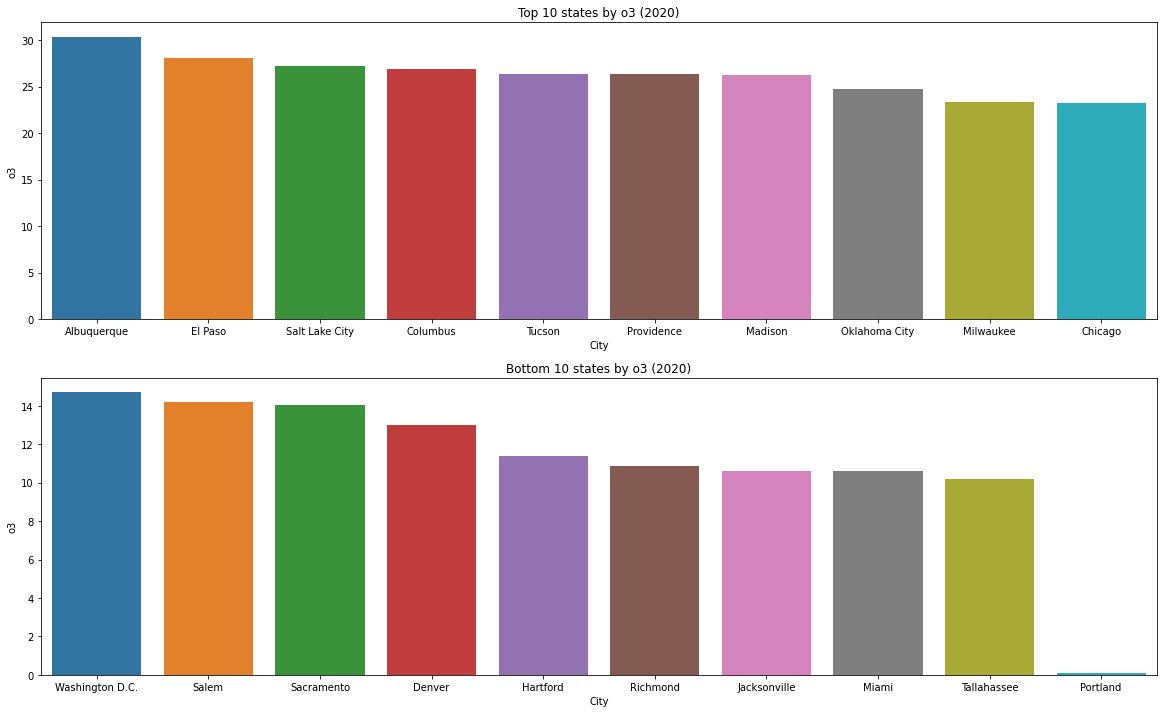

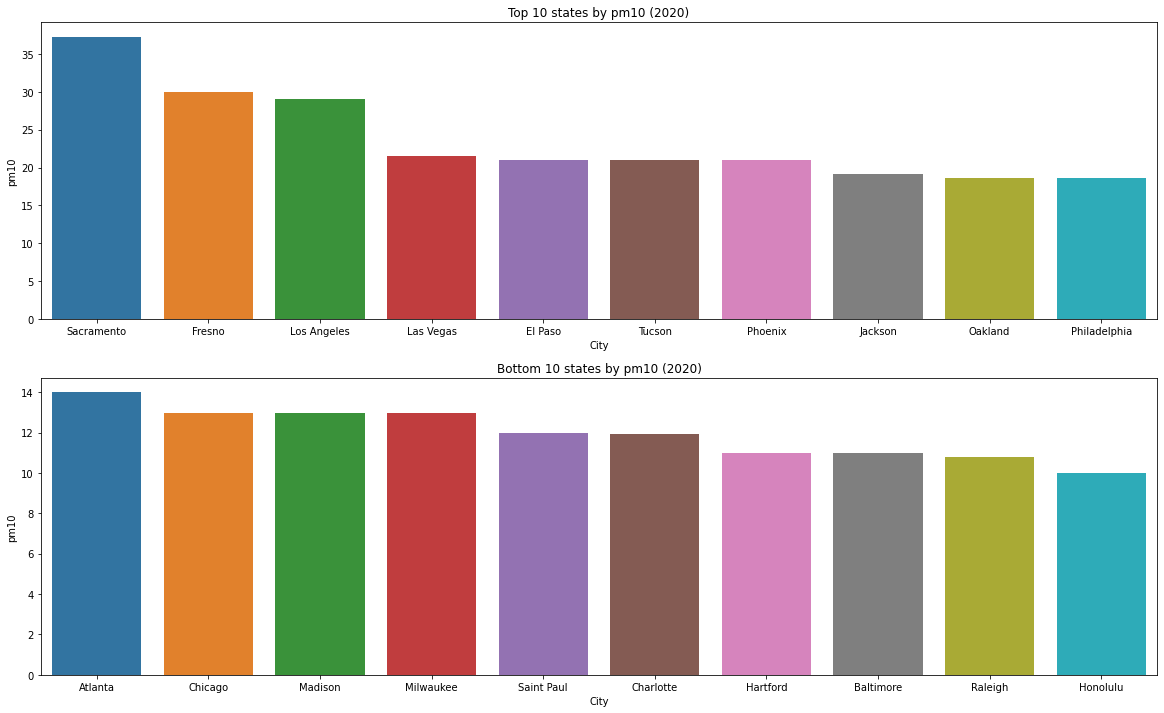

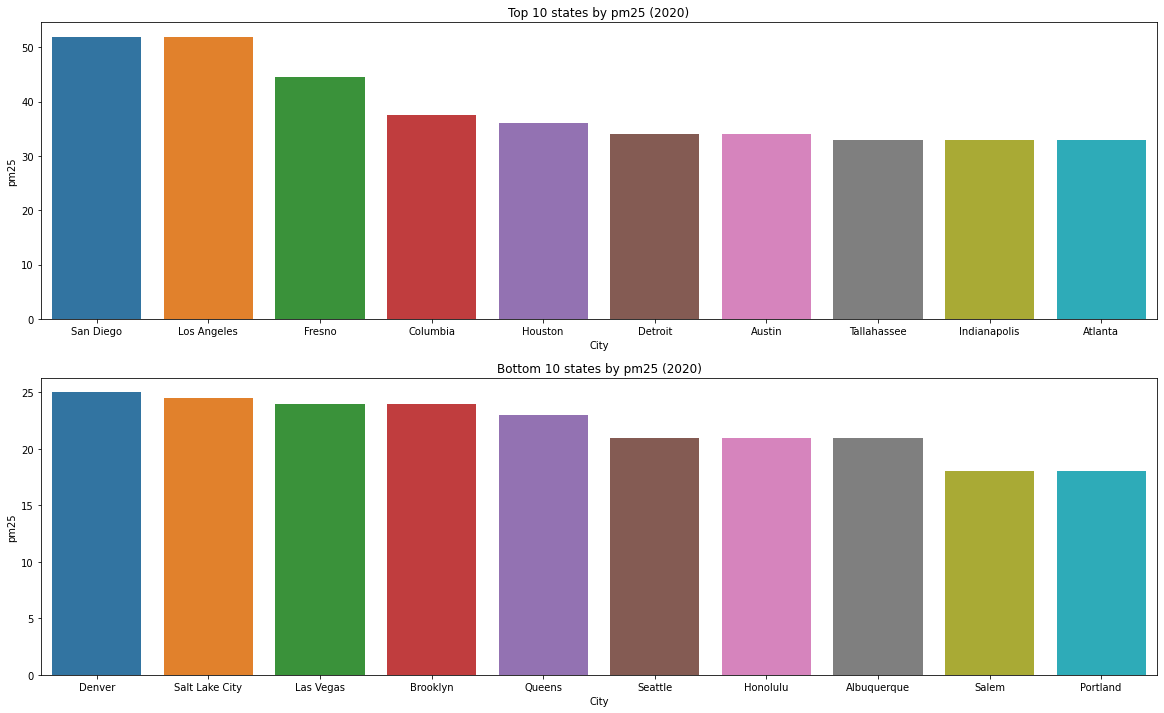

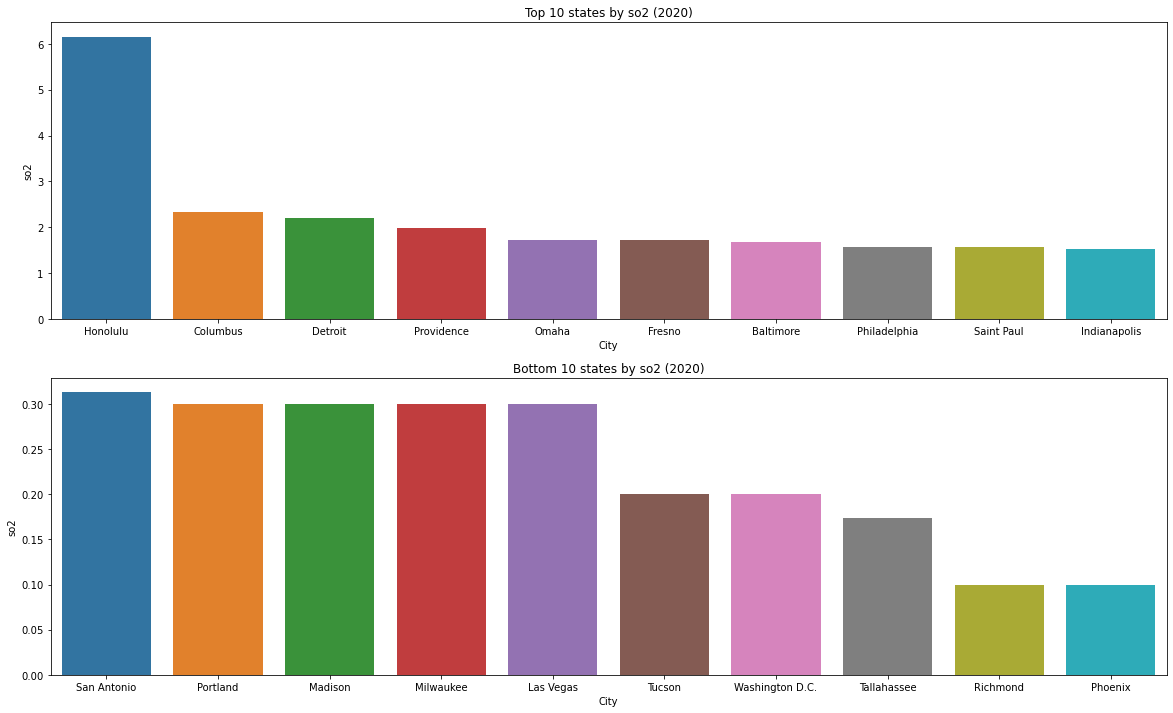

In [83]:
top_and_bottom_10_states("co")
top_and_bottom_10_states("no2")
top_and_bottom_10_states("o3")
top_and_bottom_10_states("pm10")
top_and_bottom_10_states("pm25")
top_and_bottom_10_states("so2")

In [84]:
# defining a function to find the highest ever recorded levels for a given indicator (defaults to SO2) by state
# sidenote: mostly outliers
def highest_levels_recorded(indicator="so2"):
    plt.figure(figsize=(20,10))
    ind = df_2020_USA_FINAL[[indicator, 'City', 'Date']].groupby('City', as_index=False).max()
    highest = sns.barplot(x='City', y=indicator, data=ind)
    highest.set_title("Highest ever {} levels recorded by City".format(indicator))
    plt.xticks(rotation=90)

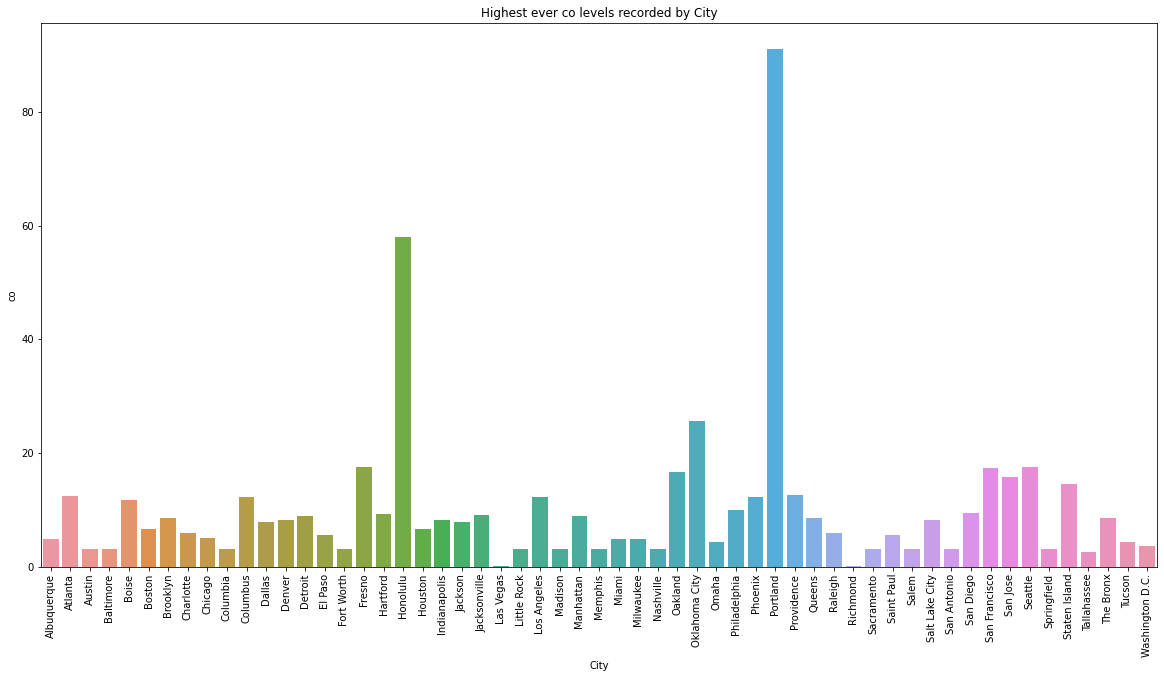

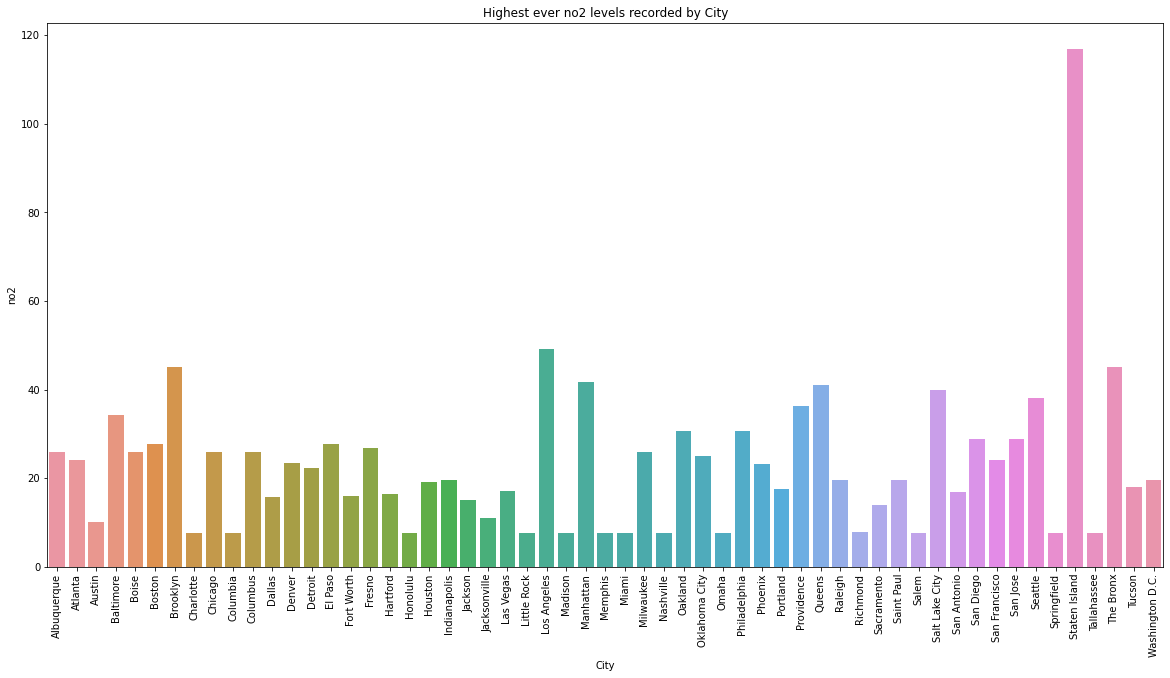

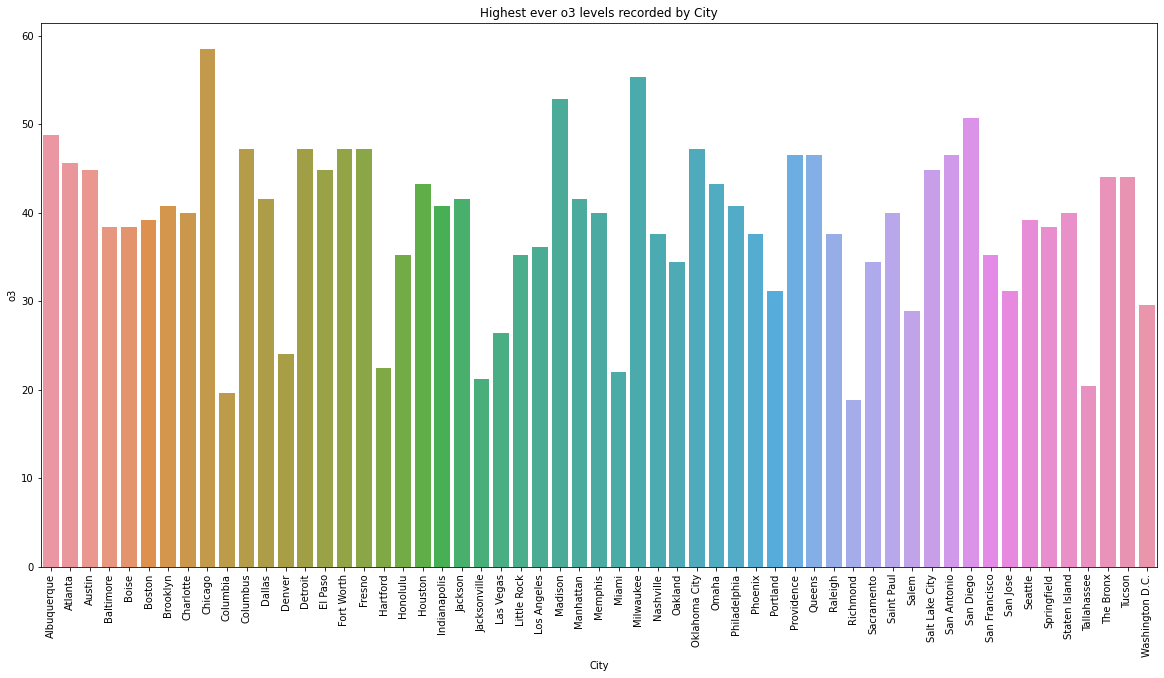

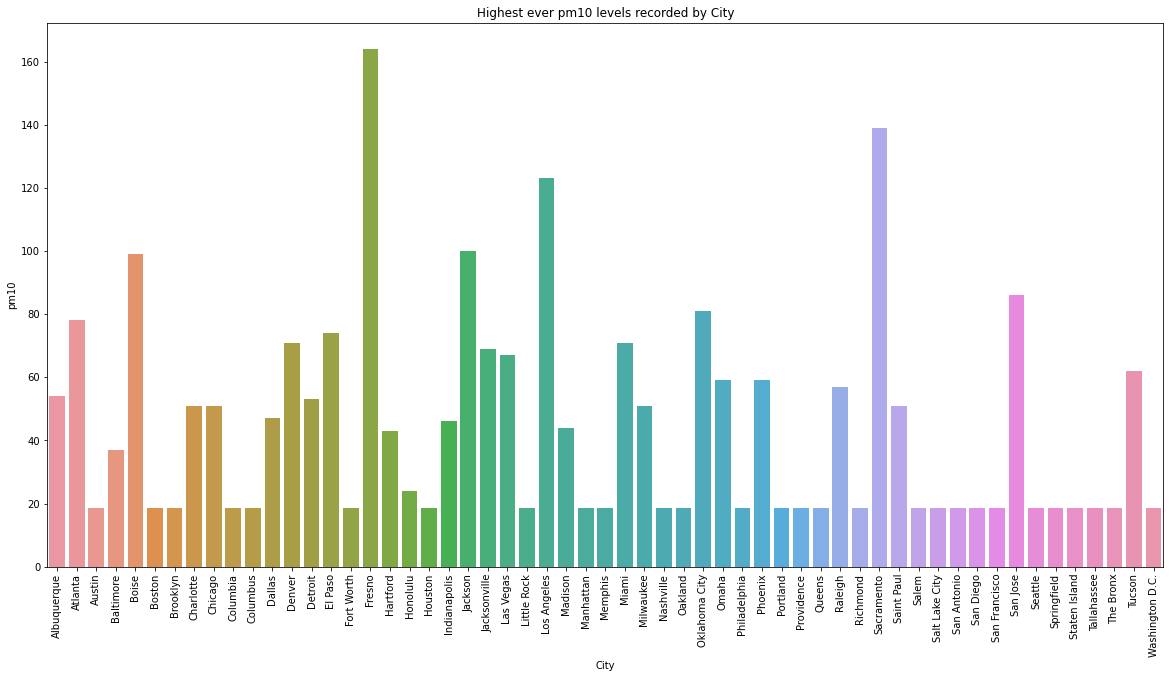

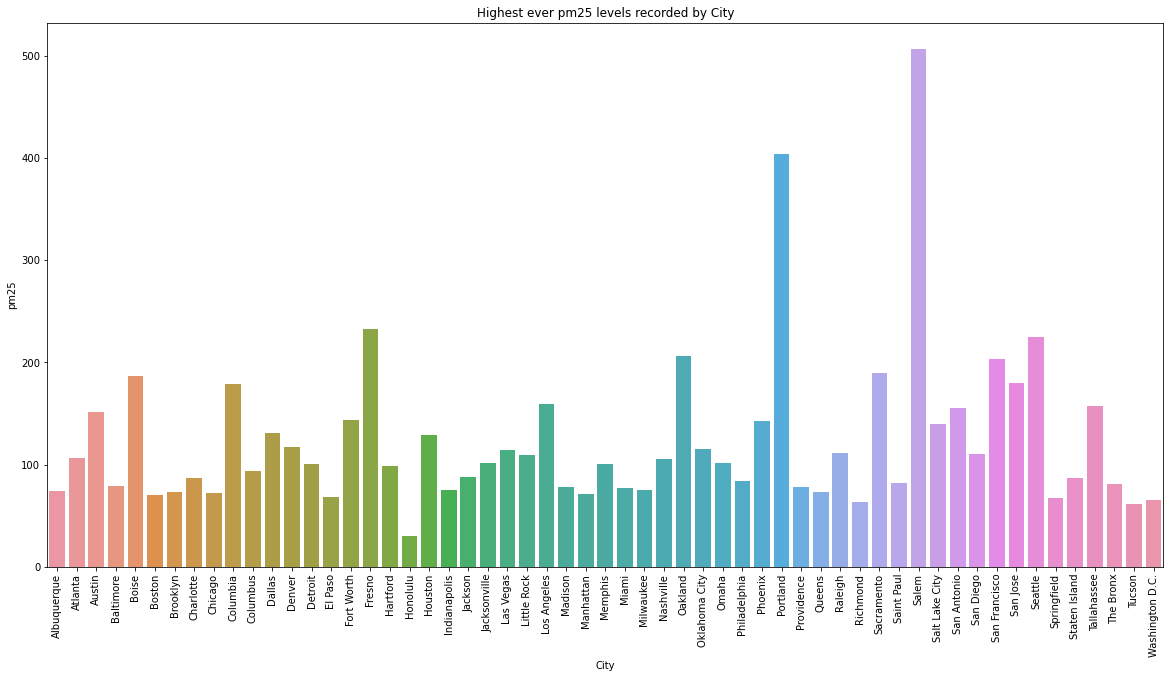

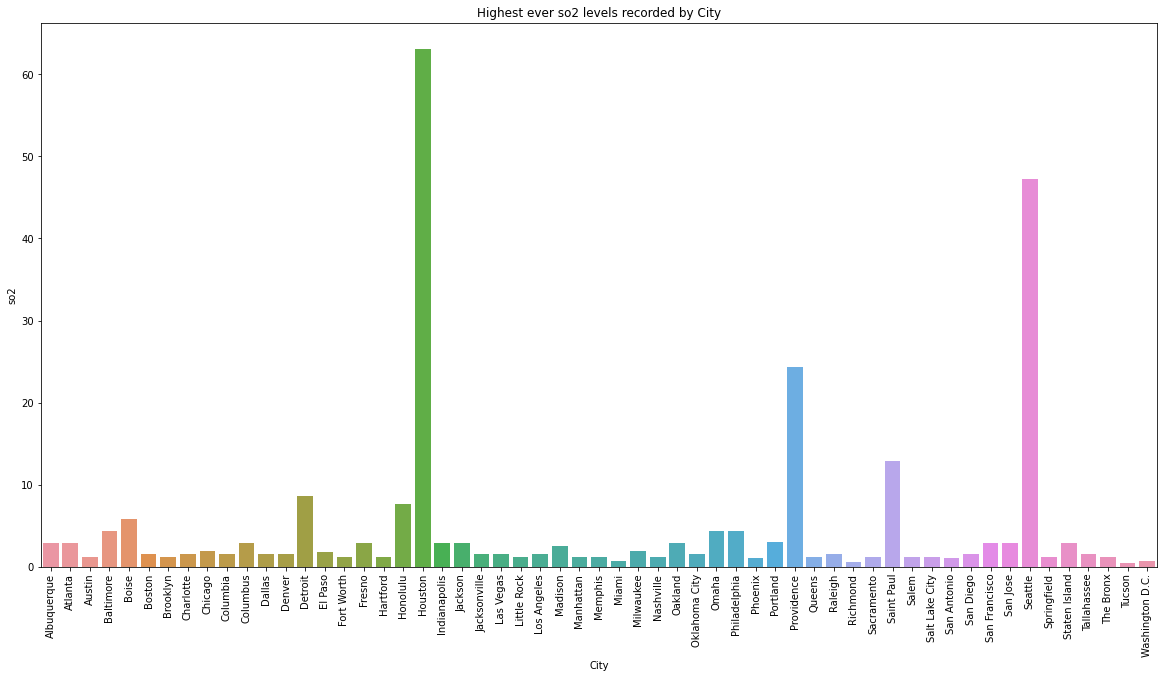

In [85]:
highest_levels_recorded("co")
highest_levels_recorded("no2")
highest_levels_recorded("o3")
highest_levels_recorded("pm10")
highest_levels_recorded("pm25")
highest_levels_recorded("so2")

In [86]:
# Perform sorting by Date, City, Country
df_2020_USA_FINAL.sort_values(by=['Date', 'City', 'Country'], ascending=False)
df_2020_USA_FINAL.head(5)

Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2
0,2019-12-30,US,Albuquerque,2.400000,6.500000,24.8,9.000000,16.0,1.511475
1,2019-12-30,US,Atlanta,1.700000,3.800000,24.1,7.000000,15.0,0.514706
2,2019-12-30,US,Austin,3.188743,3.222785,21.6,18.581864,13.0,0.400000
3,2019-12-30,US,Baltimore,3.188743,11.200000,12.1,11.647696,14.0,1.679487
4,2019-12-30,US,Boise,2.600000,7.500000,16.0,10.000000,30.0,0.784647


In [87]:
df_2020_USA_FINAL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22031 entries, 0 to 5487
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     22031 non-null  object 
 1   Country  22031 non-null  object 
 2   City     22031 non-null  object 
 3   co       22031 non-null  float64
 4   no2      22031 non-null  float64
 5   o3       22031 non-null  float64
 6   pm10     22031 non-null  float64
 7   pm25     22031 non-null  float64
 8   so2      22031 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.7+ MB


In [88]:
# Create a python function that takes necessary pollutant values and invoke the python-aqi package to perform AQI calculation
# and return the value for each row. Here, we are considering pm25, pm10, no2 and so2. As per AQI calculation requirement, 
# we should have at least either pm25 or pm10 and two other pollutant attributes since not all pollutants are always recorded.

def getaqi(pm25, pm10, no2, so2):
    #print(pm25, pm10, no2, so2)
    myaqi = aqi.to_aqi([
        (aqi.POLLUTANT_PM25, pm25),
        (aqi.POLLUTANT_PM10, pm10),
        (aqi.POLLUTANT_NO2_1H, no2),
        (aqi.POLLUTANT_SO2_1H, so2)
    ])
    #print(myaqi)
    return myaqi

In [89]:
# Because for one of the rows pm25 is 507, which is more than 500.4 set in python-aqi library

# Set min values for pm25, pm10, no2 ans so2 as defined in https://github.com/hrbonz/python-aqi/blob/master/aqi/algos/epa.py
df_2020_USA_FINAL.loc[df_2020_USA_FINAL['pm25'] < 0, 'pm25'] = 0
df_2020_USA_FINAL.loc[df_2020_USA_FINAL['pm10'] < 0, 'pm10'] = 0
df_2020_USA_FINAL.loc[df_2020_USA_FINAL['no2'] < 0, 'no2'] = 0
df_2020_USA_FINAL.loc[df_2020_USA_FINAL['so2'] < 0, 'so2'] = 0

# Set max values for pm25, pm10, no2 ans so2 as defined in https://github.com/hrbonz/python-aqi/blob/master/aqi/algos/epa.py
df_2020_USA_FINAL.loc[df_2020_USA_FINAL['pm25'] > 500.4, 'pm25'] = 500.4
df_2020_USA_FINAL.loc[df_2020_USA_FINAL['pm10'] > 604, 'pm10'] = 604
df_2020_USA_FINAL.loc[df_2020_USA_FINAL['no2'] > 2049, 'no2'] = 2049
df_2020_USA_FINAL.loc[df_2020_USA_FINAL['so2'] > 1004, 'so2'] = 1004

In [90]:
# Apply recursive lambda to call the above AQI function for each row to populate AQI value
df_2020_USA_FINAL["aqi"] = df_2020_USA_FINAL.apply(lambda row: getaqi(row['pm25'],
                                                                     row['pm10'],
                                                                     row['no2'],
                                                                     row['so2']), axis = 1)

In [91]:
# The above calls returns AQI value as an object but we need to conver this to numeric for further analysis
df_2020_USA_FINAL[['aqi']] = df_2020_USA_FINAL[['aqi']].apply(pd.to_numeric)

In [92]:
df_2020_USA_FINAL.head(5)

Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2,aqi
0,2019-12-30,US,Albuquerque,2.400000,6.500000,24.8,9.000000,16.0,1.511475,59.0
1,2019-12-30,US,Atlanta,1.700000,3.800000,24.1,7.000000,15.0,0.514706,57.0
2,2019-12-30,US,Austin,3.188743,3.222785,21.6,18.581864,13.0,0.400000,53.0
3,2019-12-30,US,Baltimore,3.188743,11.200000,12.1,11.647696,14.0,1.679487,55.0
4,2019-12-30,US,Boise,2.600000,7.500000,16.0,10.000000,30.0,0.784647,89.0


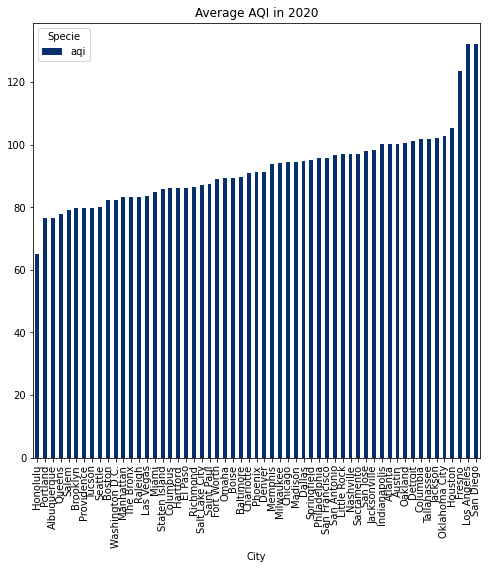

In [93]:
# Just a fun plot to see which city in USA is most polluted based on AQI value. Honolulu is healthy but LA is very bad
df_2020_USA_FINAL[['City','aqi']].groupby('City').mean().sort_values('aqi').plot(kind='bar',cmap='Blues_r',figsize=(8,8))
plt.title('Average AQI in 2020');

In [94]:
#Change the date column format from object to date
df_2020_USA_FINAL['Date'] = pd.to_datetime(df_2020_USA_FINAL['Date'])

#Split the date column in to day, moth and year for ML
df_2020_USA_FINAL['Year']= df_2020_USA_FINAL['Date'].dt.year
df_2020_USA_FINAL['Month']= df_2020_USA_FINAL['Date'].dt.month
df_2020_USA_FINAL['Day']= df_2020_USA_FINAL['Date'].dt.day
df_2020_USA_FINAL.drop('Date',1)

# Drop the date column
df_2020_final = df_2020_USA_FINAL.drop('Date',1)
rearranged_cols = ['Year','Month','Day','Country','City','co','no2','o3','pm10','pm25','aqi']
df_2020_final = df_2020_USA_FINAL [rearranged_cols]
df_2020_final.head(5)

/var/folders/dr/dd4yfyn51lxdhh0dqg_f3dvh0000gq/T/ipykernel_13189/534925530.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_2020_USA_FINAL.drop('Date',1)
/var/folders/dr/dd4yfyn51lxdhh0dqg_f3dvh0000gq/T/ipykernel_13189/534925530.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_2020_final = df_2020_USA_FINAL.drop('Date',1)


Specie,Year,Month,Day,Country,City,co,no2,o3,pm10,pm25,aqi
0,2019,12,30,US,Albuquerque,2.400000,6.500000,24.8,9.000000,16.0,59.0
1,2019,12,30,US,Atlanta,1.700000,3.800000,24.1,7.000000,15.0,57.0
2,2019,12,30,US,Austin,3.188743,3.222785,21.6,18.581864,13.0,53.0
3,2019,12,30,US,Baltimore,3.188743,11.200000,12.1,11.647696,14.0,55.0
4,2019,12,30,US,Boise,2.600000,7.500000,16.0,10.000000,30.0,89.0


In [95]:
# Write the ML ready file to a CSV
df_2020_final.to_csv('/Users/nkichili/Desktop/Synopsys/aqi_for_ml_2020.csv', index=False)

In [96]:
df_2020_sortbyaqi = df_2020_final.sort_values(by=['aqi'], ascending=False)
df_2020_sortbyaqi.head(300)

Specie,Year,Month,Day,Country,City,co,no2,o3,pm10,pm25,aqi
4342,2020,9,13,US,Salem,3.188743,7.547803,4.0,18.581864,500.4,500.0
4286,2020,9,12,US,Salem,3.188743,7.547803,1.6,18.581864,445.0,463.0
4398,2020,9,14,US,Salem,3.188743,7.547803,1.6,18.581864,427.0,452.0
4174,2020,9,10,US,Salem,3.188743,7.547803,4.0,18.581864,416.0,444.0
4335,2020,9,13,US,Portland,91.100000,10.200000,0.8,18.581864,404.0,436.0
...,...,...,...,...,...,...,...,...,...,...,...
3472,2020,8,29,US,Fresno,4.100000,5.600000,44.0,58.000000,83.0,165.0
2003,2020,11,2,US,Salem,3.188743,7.547803,1.6,18.581864,83.0,165.0
2902,2020,8,19,US,Fresno,3.900000,8.400000,23.3,62.000000,82.0,165.0
4020,2020,12,8,US,Salt Lake City,7.800000,37.100000,6.4,18.581864,82.0,165.0


In [97]:
# Write the ML ready file to a CSV with encoded values for Country and City
df_2020_final.to_csv('/Users/nkichili/Desktop/Synopsys/aqi_for_ml_2020_country_city_encoded.csv', index=False)

NameError: name 'df_final' is not defined

In [116]:
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
df_2020_final['Country_Cat'] = labelencoder.fit_transform(df_2020_final['Country'])
df_2020_final['City_Cat'] = labelencoder.fit_transform(df_2020_final['City'])
df_2020_final = df_2020_final.drop(['Country','City'], axis=1)
df_2020_final.head(5)
rearranged_cols = ['Year','Month','Day','Country_Cat','City_Cat','co','no2','o3','pm10','pm25','aqi']
df_2020_final = df_2020_final [rearranged_cols]
df_2020_final.head(5)
df_2020_final.head(-5)

/var/folders/dr/dd4yfyn51lxdhh0dqg_f3dvh0000gq/T/ipykernel_13189/3567204704.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020_final['Country_Cat'] = labelencoder.fit_transform(df_2020_final['Country'])


Specie,Year,Month,Day,Country_Cat,City_Cat,co,no2,o3,pm10,pm25,aqi
0,2019,12,30,0,0,2.400000,6.500000,24.800000,9.000000,16.0,59.0
1,2019,12,30,0,1,1.700000,3.800000,24.100000,7.000000,15.0,57.0
2,2019,12,30,0,2,3.188743,3.222785,21.600000,18.581864,13.0,53.0
3,2019,12,30,0,3,3.188743,11.200000,12.100000,11.647696,14.0,55.0
4,2019,12,30,0,4,2.600000,7.500000,16.000000,10.000000,30.0,89.0
...,...,...,...,...,...,...,...,...,...,...,...
5478,2021,1,3,0,47,5.000000,10.200000,12.800000,18.581864,60.0,153.0
5479,2021,1,3,0,48,5.800000,9.300000,14.500000,18.581864,46.0,127.0
5480,2021,1,3,0,49,4.700000,9.300000,10.400000,15.153191,53.0,144.0
5481,2021,1,3,0,50,1.800000,7.500000,24.800000,18.581864,15.0,57.0


In [117]:
# Write the ML ready file to a CSV
df_2020_final.to_csv('/Users/nkichili/Desktop/Synopsys/aqi_for_ml_2020_country_city_encoded.csv', index=False)

In [118]:
# Data Processing for ML
# Assign the first 9 columns to the X variable
df_2020_X = df_2020_final.drop(['aqi'], axis=1)
df_2020_X.head(5)

# Assign the last column, aqi, to the Y variable
df_2020_y = df_2020_final.iloc[:,-1]

# Add a column named predicted aqi and assign 0s
df_2020_final["predicted aqi"]= 0

In [119]:
# load the model from disk
lr = joblib.load('aqi_model.sav')
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [120]:
df_2020_X.head(5)

df_2020_lr_pred = lr.predict(df_2020_X)

df_2020_lr_pred

df_2020_X['predicted aqi'] = df_2020_lr_pred
df_2020_X.head(5)

Specie,Year,Month,Day,Country_Cat,City_Cat,co,no2,o3,pm10,pm25,predicted aqi
0,2019,12,30,0,0,2.400000,6.500000,24.8,9.000000,16.0,60.320181
1,2019,12,30,0,1,1.700000,3.800000,24.1,7.000000,15.0,58.479992
2,2019,12,30,0,2,3.188743,3.222785,21.6,18.581864,13.0,53.062555
3,2019,12,30,0,3,3.188743,11.200000,12.1,11.647696,14.0,55.481589
4,2019,12,30,0,4,2.600000,7.500000,16.0,10.000000,30.0,90.457082


In [122]:
# Now use inverse_transform to revert the changes at any time may be at the

#df_2020_X['Country'] = labelencoder.inverse_transform(df_2020_X['Country_Cat'])
df_2020_X['City'] = labelencoder.inverse_transform(df_2020_X['City_Cat'])


df_2020_X['dateInt']=df_2020_X['Year'].astype(str) + df_2020_X['Month'].astype(str).str.zfill(2)+ df_2020_X['Day'].astype(str).str.zfill(2)
df_2020_X['Date'] = pd.to_datetime(df_2020_X['dateInt'], format='%Y%m%d')
df_2020_ready = df_2020_X.drop(columns=['Year', 'Month','Day','Country_Cat','City_Cat','dateInt'])

df_2020_ready.head(5)

Specie,co,no2,o3,pm10,pm25,predicted aqi,City,Date
0,2.400000,6.500000,24.8,9.000000,16.0,60.320181,Albuquerque,2019-12-30
1,1.700000,3.800000,24.1,7.000000,15.0,58.479992,Atlanta,2019-12-30
2,3.188743,3.222785,21.6,18.581864,13.0,53.062555,Austin,2019-12-30
3,3.188743,11.200000,12.1,11.647696,14.0,55.481589,Baltimore,2019-12-30
4,2.600000,7.500000,16.0,10.000000,30.0,90.457082,Boise,2019-12-30


In [161]:
df_2020_ready.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22031 entries, 0 to 5487
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   co             22031 non-null  float64       
 1   no2            22031 non-null  float64       
 2   o3             22031 non-null  float64       
 3   pm10           22031 non-null  float64       
 4   pm25           22031 non-null  float64       
 5   predicted aqi  22031 non-null  float64       
 6   City           22031 non-null  object        
 7   Date           22031 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.5+ MB


In [162]:
df_2020_ready.to_csv('/Users/nkichili/Desktop/Synopsys/aqi_covid_2020_foranalysis.csv', index=False)

In [160]:
df_2020_top_20 = df_2020_ready[['City','predicted aqi']].groupby('City').mean().sort_values('predicted aqi', ascending = False)

df_2020_top_20.head(200)

Specie,predicted aqi
City,
Fresno,141.806962
Los Angeles,136.362891
San Diego,134.495500
Sacramento,106.792673
Houston,105.692747
Columbia,105.638994
Oakland,104.639859
San Jose,103.730860
Oklahoma City,103.184517


In [133]:
# Read City & County mapping file
df_city_county = pd.read_csv('/Users/nkichili/Desktop/Synopsys/usa_city_county.csv')
df_city_county = df_city_county.rename(columns={"city": "City"})
df_city_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   City         424 non-null    object
 1   county_name  424 non-null    object
dtypes: object(2)
memory usage: 6.8+ KB


In [134]:
df_city_county.head()

,City,county_name
0,Abilene,Taylor
1,Akron,Summit
2,Albany,Albany
3,Albuquerque,Bernalillo
4,Alexandria,Alexandria


In [128]:
df_city_county.shape

(424, 2)

In [130]:
filter_list = ['Fresno','Los Angeles','San Diego','Sacramento','Houston','Columbia','Oakland','San Jose','Oklahoma City',
'Tallahassee','Jackson','Detroit','Austin','Atlanta','Indianapolis','San Francisco','Jacksonville','San Antonio',
'Nashville','Little Rock']

df_city_filter = df_2020_ready.loc[df_2020_ready['City'].isin(filter_list)]

df_city_filter.head(200)

Specie,co,no2,o3,pm10,pm25,predicted aqi,City,Date
1,1.700000,3.800000,24.100000,7.000000,15.000000,58.479992,Atlanta,2019-12-30
2,3.188743,3.222785,21.600000,18.581864,13.000000,53.062555,Austin,2019-12-30
12,4.066556,9.097030,17.600000,22.000000,28.000000,84.834173,Detroit,2019-12-30
15,3.300000,11.200000,6.400000,20.000000,61.000000,156.340315,Fresno,2019-12-30
18,2.454688,7.833333,12.800000,18.581864,15.000000,57.049511,Houston,2019-12-30
...,...,...,...,...,...,...,...,...
566,3.188743,3.222785,25.600000,18.581864,21.000000,69.810810,Austin,2020-01-09
573,3.188743,7.547803,19.681183,18.581864,37.545455,105.362680,Columbia,2020-01-09
577,4.066556,9.097030,17.600000,15.000000,29.000000,87.102974,Detroit,2020-01-09
580,3.000000,9.300000,9.600000,13.000000,47.000000,126.234289,Fresno,2020-01-09


In [131]:
df_city_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7530 entries, 1 to 5484
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   co             7530 non-null   float64       
 1   no2            7530 non-null   float64       
 2   o3             7530 non-null   float64       
 3   pm10           7530 non-null   float64       
 4   pm25           7530 non-null   float64       
 5   predicted aqi  7530 non-null   float64       
 6   City           7530 non-null   object        
 7   Date           7530 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 529.5+ KB


In [141]:
df_aqi_2020 = pd.merge(df_city_filter, df_city_county, how='left', on=['City'])
df_aqi_2020.head()

,co,no2,o3,pm10,pm25,predicted aqi,City,Date,county_name
0,1.700000,3.800000,24.1,7.000000,15.0,58.479992,Atlanta,2019-12-30,Fulton
1,3.188743,3.222785,21.6,18.581864,13.0,53.062555,Austin,2019-12-30,Travis
2,4.066556,9.097030,17.6,22.000000,28.0,84.834173,Detroit,2019-12-30,Wayne
3,3.300000,11.200000,6.4,20.000000,61.0,156.340315,Fresno,2019-12-30,Fresno
4,2.454688,7.833333,12.8,18.581864,15.0,57.049511,Houston,2019-12-30,Harris


In [142]:
df_aqi_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7530 entries, 0 to 7529
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   co             7530 non-null   float64       
 1   no2            7530 non-null   float64       
 2   o3             7530 non-null   float64       
 3   pm10           7530 non-null   float64       
 4   pm25           7530 non-null   float64       
 5   predicted aqi  7530 non-null   float64       
 6   City           7530 non-null   object        
 7   Date           7530 non-null   datetime64[ns]
 8   county_name    7530 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 588.3+ KB


In [148]:
# Read NYT Covid Cases data file for years 2020 - 2022 Feb by county
df_covid_2017_2021 = pd.read_csv('/Users/nkichili/Desktop/Synopsys/us-counties-2020_2022 Feb.csv')

In [149]:
df_covid_2017_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231222 entries, 0 to 2231221
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Date                 object 
 1   geoid                object 
 2   county Name          object 
 3   state                object 
 4   cases                int64  
 5   cases_avg            float64
 6   cases_avg_per_100k   float64
 7   deaths               int64  
 8   deaths_avg           float64
 9   deaths_avg_per_100k  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 170.2+ MB


In [150]:
df_covid_2017_2021['Date'] = pd.to_datetime(df_covid_2017_2021['Date'])

In [151]:
# Select the required Columns
covid_cols = ['Date','county Name','cases']

# Assign a new dataframe for reduced columns
df_covid_2017_2021_cols = df_covid_2017_2021[covid_cols]
df_covid_2017_2021_cols.head()

,Date,county Name,cases
0,2020-01-21,Snohomish,1
1,2020-01-22,Snohomish,0
2,2020-01-23,Snohomish,0
3,2020-01-24,Snohomish,0
4,2020-01-24,Cook,1


In [152]:
df_covid_2017_2021_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231222 entries, 0 to 2231221
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Date         datetime64[ns]
 1   county Name  object        
 2   cases        int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 51.1+ MB


In [153]:
df_covid_2020 = df_covid_2017_2021_cols.rename(columns={"county Name": "county_name"})
df_covid_2020.head()

,Date,county_name,cases
0,2020-01-21,Snohomish,1
1,2020-01-22,Snohomish,0
2,2020-01-23,Snohomish,0
3,2020-01-24,Snohomish,0
4,2020-01-24,Cook,1


In [154]:
df_aqi_covid_merged = pd.merge(df_aqi_2020, df_covid_2020, how='left', on=['Date', 'county_name'])

In [158]:
df_aqi_covid_merged.head(2000)

,co,no2,o3,pm10,pm25,predicted aqi,City,Date,county_name,cases
0,1.700000,3.800000,24.1,7.000000,15.0,58.479992,Atlanta,2019-12-30,Fulton,NaN
1,3.188743,3.222785,21.6,18.581864,13.0,53.062555,Austin,2019-12-30,Travis,NaN
2,4.066556,9.097030,17.6,22.000000,28.0,84.834173,Detroit,2019-12-30,Wayne,NaN
3,3.300000,11.200000,6.4,20.000000,61.0,156.340315,Fresno,2019-12-30,Fresno,NaN
4,2.454688,7.833333,12.8,18.581864,15.0,57.049511,Houston,2019-12-30,Harris,NaN
...,...,...,...,...,...,...,...,...,...,...
1995,5.600000,5.600000,32.0,10.000000,18.0,64.135624,Oklahoma City,2020-03-29,Oklahoma,13.0
1996,3.188743,1.900000,24.1,37.287293,13.0,50.829133,Sacramento,2020-03-29,Sacramento,0.0
1997,3.188743,4.569630,32.8,18.581864,35.0,100.081487,San Antonio,2020-03-29,Bexar,15.0
1998,3.400000,3.800000,29.6,18.581864,25.0,78.462045,San Francisco,2020-03-29,San Francisco,35.0


In [156]:
df_aqi_covid_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22536 entries, 0 to 22535
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   co             22536 non-null  float64       
 1   no2            22536 non-null  float64       
 2   o3             22536 non-null  float64       
 3   pm10           22536 non-null  float64       
 4   pm25           22536 non-null  float64       
 5   predicted aqi  22536 non-null  float64       
 6   City           22536 non-null  object        
 7   Date           22536 non-null  datetime64[ns]
 8   county_name    22536 non-null  object        
 9   cases          21328 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 1.9+ MB


In [159]:
df_aqi_covid_merged.to_csv('/Users/nkichili/Desktop/Synopsys/aqi_covid_2020.csv', index=False)